# Consumer segmentation using k-means clustering algorithm 

This document aims to showcase how to use k-means clustering algorithm to segment consumers. We will cover the following contents:
- Importing data from GitHub
- Preprocessing data for clustering analysis
- Segmenting consumers using k-means clustering
- Extracting customer insights from clustering results
- Visualizing segmentation results


## Import data and data descriptions

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans    # Use "sklearn/cluster/KMeans" for clustering analysis
from matplotlib import pyplot as plt

We will use "MallCustomersTwoVariables.csv" for analysis. <br>
The dataset can be found at https://github.com/zoutianxin1992/MarketingAnalyticsPython/blob/main/Marketing%20Analytics%20in%20Python/Segmentation/Datasets/MallCustomersTwoVariables.csv </br>
**Remember:** When loading the data from GitHub, you need to use the **RAW** version of the dataset. </br>
If you load data from your own computer, replace "url" with the path to your dataset (it must be stored under your working directory.).

In [2]:
url = "https://raw.githubusercontent.com/zoutianxin1992/MarketingAnalyticsPython/main/Marketing%20Analytics%20in%20Python/Segmentation/Datasets/MallCustomersTwoVariables.csv"
df = pd.read_csv(url,index_col=0) # use the first column (customer id) as index

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Annual Income (k$)      200 non-null    int64
 1   Spending Score (1-100)  200 non-null    int64
dtypes: int64(2)
memory usage: 4.7 KB


## Rename variables

Right now the names of the two variables are "Annual Income (k)" and "Spending Score (1-100)". Conventionally, to increase the code readability, variable names shouldn't have spaces and special symbols (-,etc). So we need to rename the variables to "annual_income" and "spending_score". 

<a href="https://realpython.com/python-pep8/"> A guide of naming variables in Python</a>

In [3]:
df = df.rename(columns = {"Annual Income (k$)":"annual_income","Spending Score (1-100)":"spending_score"})
df.head()

,annual_income,spending_score
CustomerID,,
1,15,81
2,15,39
3,16,77
4,16,6
5,17,76


In [6]:
df.describe()

,annual_income,spending_score
count,200.000000,200.000000
mean,60.560000,50.200000
std,26.264721,25.823522
min,15.000000,1.000000
25%,41.500000,34.750000
50%,61.500000,50.000000
75%,78.000000,73.000000
max,137.000000,99.000000


### Data visualization: data distribution (optional)

When we have no more than two variables, we can intuitively look for consumer segments with a scatter plot, using "matplotlab/pyplot".

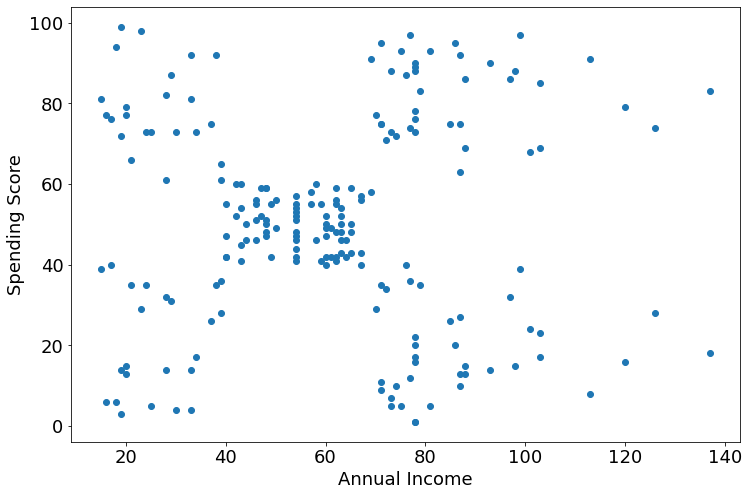

In [4]:
%matplotlib inline
# add this to guarantee Jupyter lab shows the plot

plt.rcParams['figure.figsize'] = [12,8]  # set default figure size to be 12*8 inch
df_scatter_plot = plt.scatter(df["annual_income"],df["spending_score"])   # generate the scatter plot
plt.xlabel("Annual Income", fontsize = 18)
plt.ylabel("Spending Score", fontsize = 18)     
plt.tick_params(axis = "both", labelsize = 18)  

# Alternative way to plot
# plt.scatter(df.iloc[:, 0], df.iloc[:, 1])

## Segment consumers into five segments

### Normalizing the data

Different variables are measured by  different units. In our example, annual incomes are measured by k\$, but spending scores by a 100-point scale. When this happens, we  need to "normalize" the data so the units across different variables become "apple-to-apple" comparable. One normalization method is called min-max normalization, which divides each variable by its range, so all normalized variables will be on a 0-to-1 scale.

$$
X_{transform} = \frac {X_{original} - X_{min}} {X_{max} - X_{min}}
$$

This step is essential before applying k-mean.  </br>
(An alternative normalization method is to substract a variable by its mean, and then divide it by its standard deviation. So, the mean of the normalized variable will be zero, and its standard deviation will be one.
$$
X_{transform} = \frac {X_{original} - mean(X)} {std(X)}
$$)

In [5]:
df_normalized = (df-df.min())/(df.max()-df.min())  # By default, pandas calculate maximums and minimums by columns, which serves our purpose.
df_normalized.describe()    # For both transformed variables, the minimum will be zero, and the maximum will be one.

,annual_income,spending_score
count,200.000000,200.000000
mean,0.373443,0.502041
std,0.215285,0.263505
min,0.000000,0.000000
25%,0.217213,0.344388
50%,0.381148,0.500000
75%,0.516393,0.734694
max,1.000000,1.000000


### Applying k-mean algorithm to normalized data 

In [11]:
# This cell runs the k-mean algorithm (k=5) to segment consumers into five segments
kmeanSpec = KMeans(n_clusters = 5, n_init = 100)  # setup the k-mean model specs
kmean_result5 = kmeanSpec.fit(df_normalized)    # apply the above model to the normalized data and store the result

The `n_init` parameter  tells KMeans to run clustering 100 times with 100 different initial guesses of the centroid locations. Some initial guesses may lead to "local minima" for SSE.
![local minimum](https://www.researchgate.net/profile/Yong-Ma-5/publication/267820876/figure/fig1/AS:669428953923612@1536615708709/Schematic-of-the-local-minima-problem-in-FWI-The-data-misfit-has-spurious-local-minima.png)

## Post-segmentation analysis

After applying k-mean, we want to know (1) which segment each consumer belongs to, (2) the locations of the centroids, which each represents the **average consumer** of each cluster, and (3) the number of consumers in each segment. 

### Which segment does each consumer belong to?

In [12]:
df["segment"] = kmean_result5.labels_  # add a new column "segment" indicating a consumer's segment
df.head()

,annual_income,spending_score,segment
CustomerID,,,
1,15,81,2
2,15,39,4
3,16,77,2
4,16,6,4
5,17,76,2


### Summarize segment characteristics

In [13]:
# We want to summarize, by each segment, the descriptive stats for consumers' annual incomes and spending scores
# Note we summarize the original dataset ("df"), rather than the normalized one, because only the variables in the former have real meanings.


summary_table = df.groupby("segment").aggregate({                           # groupby("X") enables the calculation is separately done for each value of X 
    "annual_income": ["mean","min","max","std"],             # calculate the mean/min/max/std of annual income for each segment
    "spending_score": ["mean","min","max","std"],            # calculate the mean/min/max/std of spending score for each segment
    "segment": "count"                                       # count how many consumers are there in each segment
}
)

summary_table

annual_income                     spending_score                     \
                 mean min  max        std           mean min max        std   
segment                                                                       
0           55.296296  39   76   8.988109      49.518519  34  61   6.530909   
1           86.538462  69  137  16.312485      82.128205  63  97   9.364489   
2           25.727273  15   39   7.566731      79.363636  61  99  10.504174   
3           88.200000  70  137  16.399067      17.114286   1  39   9.952154   
4           26.304348  15   39   7.893811      20.913043   3  40  13.017167   

        segment  
          count  
segment          
0            81  
1            39  
2            22  
3            35  
4            23

According to the table, segment 0 has 39 consumers, and an average consumer in the segment has an annual income of 86.54 thousand dollars, and a spending score of 82.13 out of 100. (86.54, 82.13) is the centroid position for segment 0. </br>
Comparing with other segments, segment 0 consumers have high incomes and high spending powers. 

### Data Visualization: segmentation results

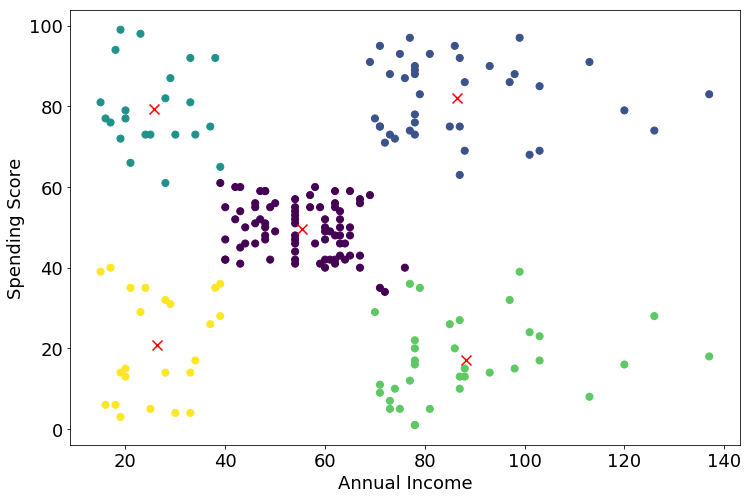

In [15]:
%matplotlib inline

# Extract centroid positions
centroids = summary_table.iloc[:,[0,4]]


# Generate segmentation plot
plt.rcParams['figure.figsize'] = [12,8] 
plt.scatter(df["annual_income"], df["spending_score"], c = df["segment"],s = 50) # "c" is color parameter, so we assign different segments with different parameters
plt.xlabel("Annual Income", fontsize = 18)
plt.ylabel("Spending Score", fontsize = 18)
plt.tick_params(axis='both', labelsize = 18)

# mark the centroids on the plot
plt.scatter(centroids.iloc[:, 0], centroids.iloc[:, 1], c = "red", marker = "x", s = 100);